In [165]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         sklearn_sm,
                         summarize)
from ISLP import confusion_table
from sklearn.model_selection import (train_test_split,
                                     cross_validate,
                                     KFold)

### 5.
> In Chapter $4$, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

> **(a)** Fit a logistic regression model that uses `income` and `balance` to predict `default`.

In [166]:
Default_df = load_data('Default')
Default_df

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [167]:
design = MS(['income', 'balance'])
X = design.fit_transform(Default_df)
y = Default_df.default == 'Yes'

In [168]:
def get_significant_predictors(summary_df, threshold=0.05):
    """Get rows with significant p-value from DataFrame"""
    return summary_df.loc[summary_df[summary_df.columns[-1]] <= threshold]

def get_accuracy(confusion_mat, decimals=4):
    return (np.trace(confusion_mat) / 
            np.sum(confusion_mat.to_numpy())).round(decimals=decimals)

def get_error_rate(confusion_mat, decimals=4):
    return (1 - get_accuracy(confusion_mat)).round(decimals=decimals)

def get_prediction(fitted_model, X, threshold=0.5):
    """Get predictions for `fitted_model`"""
    probs = fitted_model.predict(X)
    predictions = np.full(X.shape[0], False)
    predictions[probs >= threshold] = True
    return predictions

In [169]:
logit = sm.GLM(y, X,
                  family=sm.families.Binomial()).fit()
confusion_mat = confusion_table(get_prediction(logit, X), y)
print(f'Error rate: {get_error_rate(confusion_mat)}')
confusion_mat

Error rate: 0.0263


Truth,False,True
Predicted,,
False,9629,225
True,38,108


> **(b)** Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:
> <ol type="i">
> <li>Split the sample set into a training set and a validation set.</li>
> <li>Fit a multiple logistic regression model using only the training observations.</li>
> <li>Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the `default` category if the posterior probability is greater than $0.5$.</li>
> <li>Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.</li>
> </ol>


In [170]:
def validation_set(X, y, test_size=0.3, pred_threshold=0.5, rd_seed=None):
    """Validation set approach for logistic regression"""
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, 
                                                        random_state=rd_seed)
    lr_model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
    predictions = get_prediction(lr_model, X_valid, threshold=pred_threshold)
    confusion_mat = confusion_table(predictions, y_valid)
    return confusion_mat, predictions, (X_train, X_valid, y_train, y_valid), lr_model

In [171]:
confusion_mat, _, _, _ = validation_set(X, y, test_size=1-0.7)
print(f'Training size: {0.7}')
print(f'Estimated test error rate: {get_error_rate(confusion_mat)}')

Training size: 0.7
Estimated test error rate: 0.026


> **(c)** Repeat the process in $(b)$ three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

In [172]:
for seed in range(3):
    confusion_mat, _, _, _ = validation_set(X, y, rd_seed=seed)
    print(f'Random seed: {seed}')
    print(f'Estimated test error rate: {get_error_rate(confusion_mat)}')

Random seed: 0
Estimated test error rate: 0.0273
Random seed: 1
Estimated test error rate: 0.0247
Random seed: 2
Estimated test error rate: 0.0237


**A:** We can see that the division of the data set into validation set (controlled by the seed) can indeed affect the result of the estimation.

> **(d)** Now consider a logistic regression model that predicts the probability of `default` using `income`, `balance`, and a dummy variable for `student`, Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for `student` leads to a reduction in the test error rate.

In [173]:
# Model including `student`
design = MS(['income', 'balance', 'student'])
X = design.fit_transform(Default_df)
for seed in range(3):
    confusion_mat, _, _, _ = validation_set(X, y, test_size=0.5, rd_seed=seed)
    print(f'Random seed: {seed}')
    print(f'Error rate: {get_error_rate(confusion_mat)}')

Random seed: 0
Error rate: 0.0292
Random seed: 1
Error rate: 0.0262
Random seed: 2
Error rate: 0.0254


**A:** Comparing the model from part $(c)$ and the new model's result, including `student` appears to have no improvement. In fact, the average of the three validation sets appears to favor the model without `student` as a predictor.

### 6.
> We continue to consider the use of a logistic regression model to predict the probability of `default` using `income` and `balance` on the `Default` data set. In particular, we will now compute estimates for the standard errors of the `income` and `balance` logistic regression coefficients in two different ways: $(1)$ using the bootstrap, $(2)$ using the standard formula for computing the standard error in the `sm.GLM()` function. Do not forget to set a random seed before beginning your analysis.

> **(a)** Using the `summarize()` and `sm.GLM()` functions, determine the estimated standard errors for the coefficients associated with `income` and `balance` in a multiple logistic regression model that uses both predictors.

In [174]:
design = MS(['income', 'balance'])
X = design.fit_transform(Default_df)
logit = sm.GLM(y, X, family=sm.families.Binomial()).fit()
summarize(logit)

,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
income,0.000021,0.000005,4.174,0.0
balance,0.005600,0.000000,24.835,0.0


> **(b)** Write a function, `boot_fn()`, that takes as input the `Default` data set as well as an index of the observations, and that outputs the coefficient estimates for `income` and `balance` in the multiple logistic regression model.

In [175]:
def boot_fn(dataset, idx):
    """Find estimates for `income` and `balance`"""
    design = MS(['income', 'balance'])
    X = design.fit_transform(Default_df).iloc[idx]
    y = (dataset.default == 'Yes').iloc[idx]
    logit = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    summary = summarize(logit)
    income_se = summary['coef']['income']
    balance_se = summary['coef']['balance']
    return income_se, balance_se

> **(c)** Following the bootstrap example in the lab, use your `boot_fn()` function to estimate the standard errors in the logistic regression coefficients for `income` and `balance`.

In [176]:
def boot_SE(func, dataset, n=None, B=1000, seed=0):
    """Perform bootstrap to find SE for `income` and `balance`
    
    Note: SE = sqrt( Var ) = sqrt( E[X^2] - (E[X])^2 )

    Parameters
    ----------
    func : function
        Function to find SE of `income` and `balance` at given indices
    dataset
        Dataset to perform bootstrap
    n : int
        Size of each bootstrap
    B : int
        Number of bootstraps
    seed : int
        Seed for random number generator
    """
    rng = np.random.default_rng(seed)
    first_income, second_income = 0, 0
    first_balance, second_balance = 0, 0
    n = n or dataset.shape[0]
    for _ in range(B):
        idx =  rng.choice(dataset.index, n, replace=True)
        income_se, balance_se = func(dataset, idx)
        first_income += income_se
        second_income += income_se**2
        first_balance += balance_se
        second_balance += balance_se**2
    return (np.sqrt(second_income / B - (first_income / B)**2), 
            np.sqrt(second_balance / B - (first_balance / B)**2))

In [177]:
boot_SE(boot_fn, Default_df, n=Default_df.shape[0], B=1000)

(4.767215650997462e-06, 0.0002334009425870289)

> **(d)** Comment on the estimated standard errors obtained using the `sm.OLS()` function and using the bootstrap.

**A:** Comparing to results from $(a)$, the _standard error_ for `income` matches well. However, `balance` is off. <br><br>
_Note_: I suspect that I have done something wrong with fitting model that uses the full data set.

### 7.
> In Sections $5.1.2$ and $5.1.3$, we saw that the `cross_validate()` function can be used in order to compute the $LOOCV$ test error estimate. Alternatively, one could compute those quantities using just `sm.GLM()` and the `predict()` method of the fitted model within a for loop. You will now take this approach in order to compute the $LOOCV$ error for a simple logistic regression model on the `Weekly` data set. Recall that in the context of classification problems, the $LOOCV$ error is given in $(5.4)$.

> **(a)** Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2`.

In [178]:
Weekly_df = load_data('Weekly')
Weekly_df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [179]:
design = MS(['Lag1', 'Lag2'])
X = design.fit_transform(Weekly_df)
y = Weekly_df.Direction == 'Up'
logit = sm.GLM(y, X, family=sm.families.Binomial()).fit()

predictions = get_prediction(logit, X)
confusion_mat = confusion_table(predictions, y)
get_error_rate(confusion_mat)


0.4444

> **(b)** Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2` _using all but the first observation_.

In [180]:
design = MS(['Lag1', 'Lag2'])
X = design.fit_transform(Weekly_df)[1:]
y = (Weekly_df.Direction == 'Up')[1:]
logit = sm.GLM(y, X, family=sm.families.Binomial()).fit()

predictions = get_prediction(logit, X)
confusion_mat = confusion_table(predictions, y)
get_error_rate(confusion_mat)

0.443

> **(c)** Use the model from $(b)$ to predict the direction of the first observation. You can do this by predicting that the first observation will go up if $P(\text{Direction = "Up"|Lag1, Lag1}) \geq 0.5$. Was this observation correctly classified?

In [181]:
print("Prediction: Up" if (logit.predict(X.iloc[0]) > 0.5).bool() 
      else "Prediction: Down")
print("True y: Up" if y.iloc[0] else "True y: Down")

Prediction: Up
True y: Down


/var/folders/pd/8hy6tr792sb5d5lgkbz_wpp40000gn/T/ipykernel_1869/3346578582.py:1: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  print("Prediction: Up" if (logit.predict(X.iloc[0]) > 0.5).bool()


In [182]:
(logit.predict(X.iloc[0]) > 0.5) != y.iloc[0]

None    True
dtype: bool

**A:** The prediction was incorrect.

> **(d)** Write a for loop from $i = 1$ to $i = n$, where $n$ is the number of observations in the data set, that performs each of the following steps:
> <ol type='i'>
> <li> Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2.</li>
> <li>Compute the posterior probability of the market moving up for the ith observation.</li>
> <li>Use the posterior probability for the ith observation in order to predict whether or not the market moves up.</li>
> <li>Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.</li>
> </ol>

In [183]:
design = MS(['Lag1', 'Lag2'])
X = design.fit_transform(Weekly_df)
y = (Weekly_df.Direction == 'Up')

num_correct = 0
for i in range(X.shape[0]):
    design = MS(['Lag1', 'Lag2'])
    X = design.fit_transform(Weekly_df)
    y = (Weekly_df.Direction == 'Up')
    X_train = X.drop([i])
    y_train = y.drop([i])
    logit = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
    num_correct += (logit.predict(X.iloc[i]) > 0.5) == y.iloc[i]
num_correct

None    599
dtype: int64

> **(e)** Take the average of the $n$ numbers obtained in $(d)iv$ in order to obtain the $LOOCV$ estimate for the test error. Comment on the results.

In [184]:
print(f'Estimated test error: {1 - (num_correct/X.shape[0]).item()}')

Estimated test error: 0.4499540863177227


**A:** The test error rate is less than $50\%$ meaning the model is doing better than random guess.

### 8.
> We will now perform cross-validation on a simulated data set.

> **(a)** Generate a simulated data set as followed:

In [185]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

> In this data set, what is $n$ and what is $p$? Write out the model used to generate the data in equation form.

**A:** There are $100$ observations so $n=100$ <br>
$y$ is model only by $x$ so $p=1$ <br><br>
The full model is:
$$ y = x - 2x^2 + \epsilon $$

> **(b)** Create a scatterplot of $X$ against $Y$. Comment on what you find.

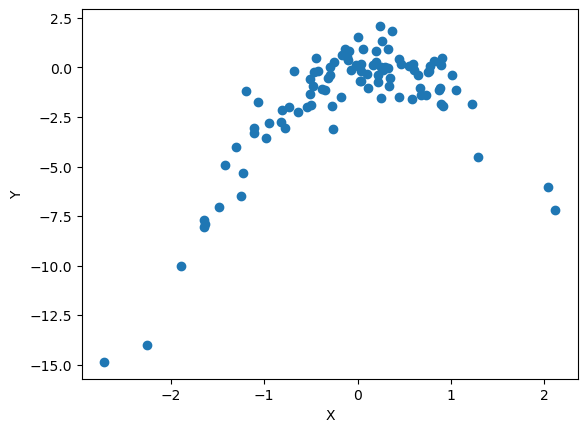

In [186]:
_, ax = subplots()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(x, y);

**A:** It follows the expected negative quadratic relationship between $x$ and $y$.

> **(c)** Set a random seed, and then compute the LOOCV error that result from fitting the following four models using least squares:
> - $Y = \beta_0 + \beta_1 X + \epsilon$
> - $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon$
> - $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$
> - $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 + \epsilon$
> <!-- end list -->
> Note you may find it helpful to use the `data.frame()` function to create a single data set containing both $X$ and $Y$.

In [187]:
cv_errors = np.zeros(4)
model = sklearn_sm(sm.OLS)
loocv = KFold(n_splits=x.shape[0],
              shuffle=True,
              random_state=0)
# Notice that I use `neg_MSE` here, hence the negation when updating `cv_errors`
for i, d in enumerate(range(1, 5)):
    X = np.power.outer(x, np.arange(d+1))
    M_CV = cross_validate(model,
                            X,
                            y,
                            scoring='neg_mean_squared_error',
                            cv=loocv)
    cv_errors[i] = - np.mean(M_CV['test_score'])

for i, model in enumerate(cv_errors):
    print(f'Model includes up to x^{1+i}: {cv_errors[i]}')

Model includes up to x^1: 6.633029839181984
Model includes up to x^2: 1.1229368563419688
Model includes up to x^3: 1.3017965489358871
Model includes up to x^4: 1.332394269417932


> **(d)** Repeat $(c)$ using another random seed, and report your results. Are you results the same as what you got in $(c)$? why?

In [188]:
model = sklearn_sm(sm.OLS)
loocv = KFold(n_splits=x.shape[0],
              shuffle=True,
              random_state=2)
for i, d in enumerate(range(1, 5)):
    X = np.power.outer(x, np.arange(d+1))
    M_CV = cross_validate(model,
                            X,
                            y,
                            scoring='neg_mean_squared_error',
                            cv=loocv)
    cv_errors[i] = - np.mean(M_CV['test_score'])

for i, model in enumerate(cv_errors):
    print(f'Model includes up to x^{1+i}: {cv_errors[i]}')

Model includes up to x^1: 6.633029839181985
Model includes up to x^2: 1.1229368563419686
Model includes up to x^3: 1.3017965489358871
Model includes up to x^4: 1.332394269417932


**A:** The result is the same as that of $(C)$. This is understandable since LOOCV uses all observation at least once as validation set. This will always happens regardless of the order that they are in.<br>
Finding the mean of the same summation (with positions of elements inside the summation changed) does not affect the result. <br><br>
_Note_: Some of the last decimals is showing difference between the two results. This is due to __[floating point error](https://www.geeksforgeeks.org/floating-point-error-in-python/)__ caused when the order of the summation is changed and not due to the above argument.

> **(e)** Which of the models in $(c)$ had the smallest LOOCV error? Is this what you expected? Explain your answer.

**A:** The quadratic model has the best MSE. This is as expected considering that our true model shares that same relationship. <br>
More complex models suffer from over-fitting (variance) while the linear model suffers (a lot) from its wrong assumption on the true model (bias).

> **(f)** Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in $(c)$ using least squares. Do these results agree with the conclusion drawn based on the cross-validation results?

In [189]:
for i, d in enumerate(range(1, 5)):
    X = np.power.outer(x, np.arange(d+1))
    design = sm.OLS(y, X)
    model  = design.fit()
    print(f'Model includes up to x^{1+i}')
    print(summarize(model))

Model includes up to x^1
         coef  std err      t  P>|t|
const -1.4650    0.247 -5.937    0.0
x1     1.9494    0.289  6.752    0.0
Model includes up to x^2
         coef  std err       t  P>|t|
const -0.0728    0.119  -0.611  0.543
x1     0.9663    0.126   7.647  0.000
x2    -2.0047    0.091 -22.072  0.000
Model includes up to x^3
         coef  std err       t  P>|t|
const -0.0572    0.120  -0.477  0.635
x1     1.1146    0.187   5.945  0.000
x2    -2.0471    0.099 -20.673  0.000
x3    -0.0643    0.060  -1.070  0.287
Model includes up to x^4
         coef  std err       t  P>|t|
const  0.1008    0.136   0.743  0.460
x1     0.9050    0.205   4.423  0.000
x2    -2.5059    0.221 -11.336  0.000
x3     0.0338    0.073   0.466  0.642
x4     0.1042    0.045   2.309  0.023


**A:** All models agree on the significance of $x$ and $x^2$. This agrees with our conclusion from using cross-validation.

### 9.
> We will now consider the `Boston` housing data set, from the `ISLP` library.

> **(a)** Based on this data set, provide an estimate for the population mean of `medv`. Call this estimate $\hat{\mu}$

In [190]:
Boston_df = load_data('Boston')
Boston_df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [191]:
Boston_df.medv.mean()

22.532806324110677

> **(b)** Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result. <br> *HInt: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.*

In [192]:
Boston_df.medv.std() / np.sqrt(Boston_df.shape[0])

0.4088611474975351

**A:** Interpretation: the _standard error_ $\hat{\mu}$ of `medv` indicates how much 
deviation from the true $\mu$ (of `medv`) we would see if we take a sample from the population and find mean of `medv` of that sample.

> **(c)** Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from $(b)$?

In [193]:
def boot_mean_fn(dataset, idx):
    """Find SE for mean of `medv` at given indices"""
    return dataset.medv.iloc[idx].mean()

def boot_mean_SE(func, dataset, n=None, B=100, seed=0):
    """Perform bootstrap to find SE for mean of `medv` in Boston dataset
    
    Note: SE = sqrt( Var ) = sqrt( E[X^2] - (E[X])^2 )

    Parameters
    ----------
    func : function
        Function to find mean of `medv` at given indices
    dataset
        Dataset to perform bootstrap
    n : int
        Size of each bootstrap
    B : int
        Number of bootstraps
    seed : int
        Seed for random number generator
    """
    rng = np.random.default_rng(seed)
    first_ , second_ = 0, 0
    for i in range(B):
        idx = rng.choice(Boston_df.shape[0], size=n)
        se = func(Boston_df, idx)
        first_ += se
        second_ += se**2
    return np.sqrt(second_ / B - (first_ / B)**2), first_ / B

In [194]:
SE, mu_hat = boot_mean_SE(boot_mean_fn, Boston_df, n=Boston_df.shape[0], B=10000, seed=0)
SE

0.41110616476936196

**A:** The estimated standard error is very close to the previous result.

> **(d)** Based on your bootstrap estimate from $(c)$, provide a $95\%$ confidence interval for the mean of `medv`. Compare it to the results obtained by using `Boston['medv'].std()` and the two standard error rule $(3.9)$. <br>
> *Hint: You can approximate a $95\%$ confidence interval using the formula $[\hat{\mu} - 2SE(\hat{\mu}), \hat{\mu} + 2SE(\hat{\mu})]$*.

In [195]:
# mu_hat was is average mu from bootstrap
[mu_hat - 2 * SE, mu_hat + 2 * SE]

[21.71284761117278, 23.35727227025023]

In [196]:
true_mean = Boston_df['medv'].mean()
true_std = Boston_df['medv'].std()
[true_mean - 2 * true_std, true_mean + 2 * true_std]

[4.138598149351036, 40.92701449887032]

**A:** This result is as expected. `true_mean` $\sim$ `mu_hat`. `SE` is the _standard deviation_ of _estimated mean_, meaning it's much closer to the _mean_ itself. On the other hand, `true_std` is finding the _standard deviation_ of the observations to the _mean_, which is much greater.

> **(e)** Based on this dataset, provide an estimate, $\hat{\mu}_{med}$, for the median value of `medv` in the population.

In [197]:
Boston_df.medv.median()

21.2

> **(f)** We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your finding.

In [198]:
# We can utilize the same function to find SE of median using Bootstrap
def boot_med_fn(dataset, idx):
    """Find SE for median of `medv` at given indices"""
    return dataset.medv.iloc[idx].median()

SE, _ = boot_mean_SE(boot_med_fn, Boston_df, n=Boston_df.shape[0], B=10000, seed=0)
SE

0.37687862766090385

**A:** The _standard error_ for the _median_ is smaller (better) than that of the _mean_.

> **(g)** Based on this data set, provide an estimate for the tenth percentile of `medv` in Boston census tracts. call this quantity $\hat{\mu}_{0.1}$. (You can use the `np.percentile()` function.) 

In [199]:
np.percentile(Boston_df['medv'], 10)

12.75

> **(h)** Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.

In [200]:
def boot_10_fn(dataset, idx):
    """Find SE for 10 percentile of `medv` at given indices"""
    return np.percentile(dataset.medv.iloc[idx], 10)

SE, _ = boot_mean_SE(boot_10_fn, Boston_df, n=Boston_df.shape[0], B=10000, seed=0)
SE

0.5035641412764847

**A:** For a relatively small data set (`Boston` contains roughly $500$ observations), the obtained _standard error_ at $0.5$ can be consider small. This means that the estimated $10$-percentile is quite accurate.